In [1]:
import os
import math
import random
import numpy as np
import pandas as pd
import requests
import csv
import time
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import matplotlib.image as mpimg #another version of opencv display image. I think it's just rendering things that have a height, width, and color dimensionality to them

from tensorflow.keras import layers
from tensorflow.keras import Model

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator #using because this is a cnn and we want it to handle images in a fast manner
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline

import nltk
from nltk.stem import WordNetLemmatizer

# Special
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


In [2]:
def get_many_requests(subreddit, first_week_number, second_week_number):
    url = 'https://api.pushshift.io/reddit/search/submission'
    time = 1602126873-(first_week_number*604800)
    params = {
            'subreddit': subreddit,
            'size': 500,
        }
    res = requests.get(url, params)
    data = res.json()
    posts_start = data['data']
    posts_start_df = pd.DataFrame(posts_start)
    posts_start_df = posts_start_df[['subreddit', 'selftext', 'title', 'created_utc']]
    for i in range(first_week_number, second_week_number): #start at 1 because I just did zero above, which is what I'm concatenating on
        params = {
            'subreddit': subreddit,
            'size': 500,
            'before': time - i*604800 #for each week, it adds 604800 to the timestamp, so we're going back i number of weeks
        }
        res = requests.get(url, params)
        data = res.json()
        posts = data['data']
        posts_df = pd.DataFrame(posts)
        posts_start_df = pd.concat([posts_start_df, posts_df], ignore_index=True)
        posts_start_df = posts_start_df[['subreddit', 'selftext', 'title', 'created_utc']]
    return posts_start_df

In [3]:
#try to automate:
def get_weekly_requests(subreddit, max_weeks):
    #specify a list that's every 10, up till max weeks, starting from 10 (10, 20, 30, 40)
    list_a = list(range(10, max_weeks+1, 10))
    list_a_minus_one = list(range(9, max_weeks+1, 10))
    #specify a list that's every 10, starting from 1 (1, 11, 21, 31)
    list_b = list(range(1, max_weeks+1, 10))
    list_b_plus_one = list(range(2, max_weeks+1, 10))
    #get requests from the days between each of the values in the list
    df_init = pd.DataFrame()
    for x in range(len(list_a)):
        try:
            df = get_many_requests(subreddit=subreddit, first_week_number=list_b[x], second_week_number=list_a[x])

            df_drop = df.loc[df['selftext'].str.split().str.len() > 4]
            df_drop = df_drop.loc[df_drop['title'].str.split().str.len() > 4]
            df_drop = df_drop.drop_duplicates()

            df_init = pd.concat([df_init, df_drop], ignore_index=True)
        except:
            pass
        try:
            df = get_many_requests(subreddit=subreddit, first_week_number=list_b_plus_one[x], second_week_number=list_a_minus_one[x])

            df_drop = df.loc[df['selftext'].str.split().str.len() > 4]
            df_drop = df_drop.loc[df_drop['title'].str.split().str.len() > 4]
            df_drop = df_drop.drop_duplicates()

            df_init = pd.concat([df_init, df_drop], ignore_index=True)
        except:
            pass
        
        
    return df_init

In [4]:
df_phys = get_weekly_requests('physics', 60)

In [5]:
df_phys.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1198 entries, 0 to 1197
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    1198 non-null   object
 1   selftext     1198 non-null   object
 2   title        1198 non-null   object
 3   created_utc  1198 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 37.6+ KB


In [6]:
df_chem = get_weekly_requests('chemistry', 60)

In [7]:
df_chem.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Empty DataFrame

# Well, automation didn't work. Let's try something else:

## Physics DF:

In [9]:
phys_df_0_10 = get_many_requests('physics', 1, 10)
phys_df_drop_0_10 = phys_df_0_10.loc[phys_df_0_10['selftext'].str.split().str.len() > 4]
phys_df_drop_0_10 = phys_df_drop_0_10.loc[phys_df_drop_0_10['title'].str.split().str.len() > 4]
phys_df_drop_0_10 = phys_df_drop_0_10.drop_duplicates()
phys_df_drop_0_10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356 entries, 1 to 999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    356 non-null    object
 1   selftext     356 non-null    object
 2   title        356 non-null    object
 3   created_utc  356 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 13.9+ KB


In [11]:
phys_df_10_19 = get_many_requests('physics', 11, 19)
phys_df_drop_10_19 = phys_df_10_19.loc[phys_df_10_19['selftext'].str.split().str.len() > 4]
phys_df_drop_10_19 = phys_df_drop_10_19.loc[phys_df_drop_10_19['title'].str.split().str.len() > 4]
phys_df_drop_10_19 = phys_df_drop_10_19.drop_duplicates()
phys_df_drop_10_19.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239 entries, 1 to 897
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    239 non-null    object
 1   selftext     239 non-null    object
 2   title        239 non-null    object
 3   created_utc  239 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 9.3+ KB


In [12]:
phys_df_20_29 = get_many_requests('physics', 21, 29)
phys_df_drop_20_29 = phys_df_20_29.loc[phys_df_20_29['selftext'].str.split().str.len() > 4]
phys_df_drop_20_29 = phys_df_drop_20_29.loc[phys_df_drop_20_29['title'].str.split().str.len() > 4]
phys_df_drop_20_29 = phys_df_drop_20_29.drop_duplicates()
phys_df_drop_20_29.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322 entries, 1 to 898
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    322 non-null    object
 1   selftext     322 non-null    object
 2   title        322 non-null    object
 3   created_utc  322 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 12.6+ KB


In [15]:
phys_df_30_39 = get_many_requests('physics', 30, 39)
phys_df_drop_30_39 = phys_df_30_39.loc[phys_df_30_39['selftext'].str.split().str.len() > 4]
phys_df_drop_30_39 = phys_df_drop_30_39.loc[phys_df_drop_30_39['title'].str.split().str.len() > 4]
phys_df_drop_30_39 = phys_df_drop_30_39.drop_duplicates()
phys_df_drop_30_39.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318 entries, 1 to 988
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    318 non-null    object
 1   selftext     318 non-null    object
 2   title        318 non-null    object
 3   created_utc  318 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 12.4+ KB


In [20]:
phys_df_40_49 = get_many_requests('physics', 40, 49)
phys_df_drop_40_49 = phys_df_40_49.loc[phys_df_40_49['selftext'].str.split().str.len() > 4]
phys_df_drop_40_49 = phys_df_drop_40_49.loc[phys_df_drop_40_49['title'].str.split().str.len() > 4]
phys_df_drop_40_49 = phys_df_drop_40_49.drop_duplicates()
phys_df_drop_40_49.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306 entries, 1 to 999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    306 non-null    object
 1   selftext     306 non-null    object
 2   title        306 non-null    object
 3   created_utc  306 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 12.0+ KB


In [21]:
phys_df_50_59 = get_many_requests('physics', 50, 59)
phys_df_drop_50_59 = phys_df_50_59.loc[phys_df_50_59['selftext'].str.split().str.len() > 4]
phys_df_drop_50_59 = phys_df_drop_50_59.loc[phys_df_drop_50_59['title'].str.split().str.len() > 4]
phys_df_drop_50_59 = phys_df_drop_50_59.drop_duplicates()
phys_df_drop_50_59.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334 entries, 1 to 997
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    334 non-null    object
 1   selftext     334 non-null    object
 2   title        334 non-null    object
 3   created_utc  334 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 13.0+ KB


In [22]:
#now concatenate all of these to get one final dataframe
phys_df = pd.concat([phys_df_drop_0_10, 
                     phys_df_drop_10_19, 
                     phys_df_drop_20_29, 
                     phys_df_drop_30_39,
                     phys_df_drop_40_49,
                     phys_df_drop_50_59
                    ], ignore_index=True)

In [23]:
phys_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1875 entries, 0 to 1874
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    1875 non-null   object
 1   selftext     1875 non-null   object
 2   title        1875 non-null   object
 3   created_utc  1875 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 58.7+ KB


## Chemistry DF:

In [24]:
chem_df_0_10 = get_many_requests('chemistry', 1, 10)
chem_df_drop_0_10 = chem_df_0_10.loc[chem_df_0_10['selftext'].str.split().str.len() > 4]
chem_df_drop_0_10 = chem_df_drop_0_10.loc[chem_df_drop_0_10['title'].str.split().str.len() > 4]
chem_df_drop_0_10 = chem_df_drop_0_10.drop_duplicates()
chem_df_drop_0_10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 7 to 996
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    297 non-null    object
 1   selftext     297 non-null    object
 2   title        297 non-null    object
 3   created_utc  297 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 11.6+ KB


In [25]:
chem_df_10_19 = get_many_requests('chemistry', 11, 19)
chem_df_drop_10_19 = chem_df_10_19.loc[chem_df_10_19['selftext'].str.split().str.len() > 4]
chem_df_drop_10_19 = chem_df_drop_10_19.loc[chem_df_drop_10_19['title'].str.split().str.len() > 4]
chem_df_drop_10_19 = chem_df_drop_10_19.drop_duplicates()
chem_df_drop_10_19.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 248 entries, 7 to 898
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    248 non-null    object
 1   selftext     248 non-null    object
 2   title        248 non-null    object
 3   created_utc  248 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 9.7+ KB


In [26]:
chem_df_20_29 = get_many_requests('chemistry', 20, 29)
chem_df_drop_20_29 = chem_df_20_29.loc[chem_df_20_29['selftext'].str.split().str.len() > 4]
chem_df_drop_20_29 = chem_df_drop_20_29.loc[chem_df_drop_20_29['title'].str.split().str.len() > 4]
chem_df_drop_20_29 = chem_df_drop_20_29.drop_duplicates()
chem_df_drop_20_29.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312 entries, 7 to 999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    312 non-null    object
 1   selftext     312 non-null    object
 2   title        312 non-null    object
 3   created_utc  312 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 12.2+ KB


In [32]:
chem_df_30_39 = get_many_requests('chemistry', 30, 38)
chem_df_drop_30_39 = chem_df_30_39.loc[chem_df_30_39['selftext'].str.split().str.len() > 4]
chem_df_drop_30_39 = chem_df_drop_30_39.loc[chem_df_drop_30_39['title'].str.split().str.len() > 4]
chem_df_drop_30_39 = chem_df_drop_30_39.drop_duplicates()
chem_df_drop_30_39.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330 entries, 7 to 897
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    330 non-null    object
 1   selftext     330 non-null    object
 2   title        330 non-null    object
 3   created_utc  330 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 12.9+ KB


In [39]:
chem_df_40_49 = get_many_requests('chemistry', 40, 49)
chem_df_drop_40_49 = chem_df_40_49.loc[chem_df_40_49['selftext'].str.split().str.len() > 4]
chem_df_drop_40_49 = chem_df_drop_40_49.loc[chem_df_drop_40_49['title'].str.split().str.len() > 4]
chem_df_drop_40_49 = chem_df_drop_40_49.drop_duplicates()
chem_df_drop_40_49.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 375 entries, 7 to 998
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    375 non-null    object
 1   selftext     375 non-null    object
 2   title        375 non-null    object
 3   created_utc  375 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 14.6+ KB


In [40]:
chem_df_50_59 = get_many_requests('chemistry', 50, 59)
chem_df_drop_50_59 = chem_df_50_59.loc[chem_df_50_59['selftext'].str.split().str.len() > 4]
chem_df_drop_50_59 = chem_df_drop_50_59.loc[chem_df_drop_50_59['title'].str.split().str.len() > 4]
chem_df_drop_50_59 = chem_df_drop_50_59.drop_duplicates()
chem_df_drop_50_59.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 409 entries, 7 to 998
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    409 non-null    object
 1   selftext     409 non-null    object
 2   title        409 non-null    object
 3   created_utc  409 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 16.0+ KB


In [41]:
chem_df = pd.concat([chem_df_drop_0_10, 
                     chem_df_drop_10_19, 
                     chem_df_drop_20_29, 
                     chem_df_drop_30_39,
                     chem_df_drop_40_49,
                     chem_df_drop_50_59
                    ], ignore_index=True)

In [42]:
chem_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971 entries, 0 to 1970
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    1971 non-null   object
 1   selftext     1971 non-null   object
 2   title        1971 non-null   object
 3   created_utc  1971 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 61.7+ KB


## All together, now:

In [43]:
df_clean = pd.concat([phys_df, chem_df], ignore_index=True)

In [44]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3846 entries, 0 to 3845
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    3846 non-null   object
 1   selftext     3846 non-null   object
 2   title        3846 non-null   object
 3   created_utc  3846 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 120.3+ KB


In [45]:
df_clean.head()

,subreddit,selftext,title,created_utc
0,Physics,I am planning to set up a home PC with AMD Ryz...,Choice of GPU for running MD simulation (NAMD ...,1602229416
1,Physics,"Ok, So I have a bit of a bizarre question. (I ...",Balance Bird vs Spin top,1602217793
2,Physics,Would this account for spin? Observations in ...,Do electrons have convective cores?,1602209419
3,Physics,According to the [Bekenstein bound](https://en...,Is quantum computing dangerous or impposible?,1602197913
4,Physics,"So I understand conceptually the Big Rip, but ...","On The Big Rip, and The Mighty Quark",1602195737


In [50]:
# Create csv of data:
df_clean.to_csv(r'./data/phys_chem_reddit_data.csv', index = False)

# This is supposed to be in the 'Modeling' code

In [ ]:
#this also assumes we have gone through preprocessing

## Naive Bayes

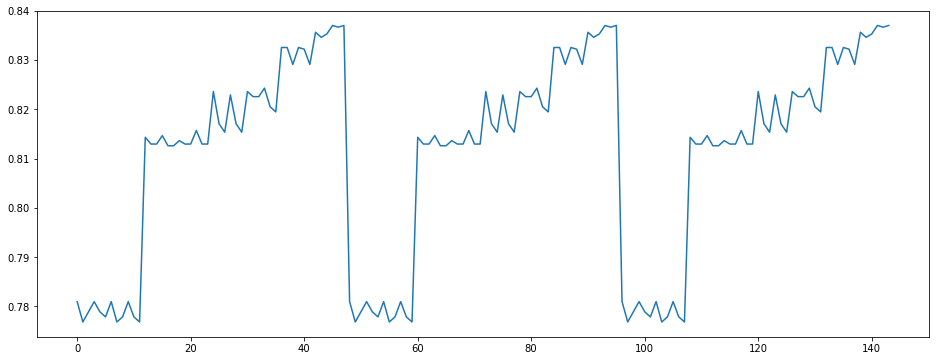

In [65]:
#results
pd.DataFrame(grid.cv_results_)['mean_test_score'].plot(figsize = (16, 6))

In [66]:
#examine the best parameters
grid.best_params_

{'countvectorizer__max_df': 0.5,
 'countvectorizer__max_features': 200,
 'countvectorizer__min_df': 10,
 'countvectorizer__ngram_range': (1, 3)}

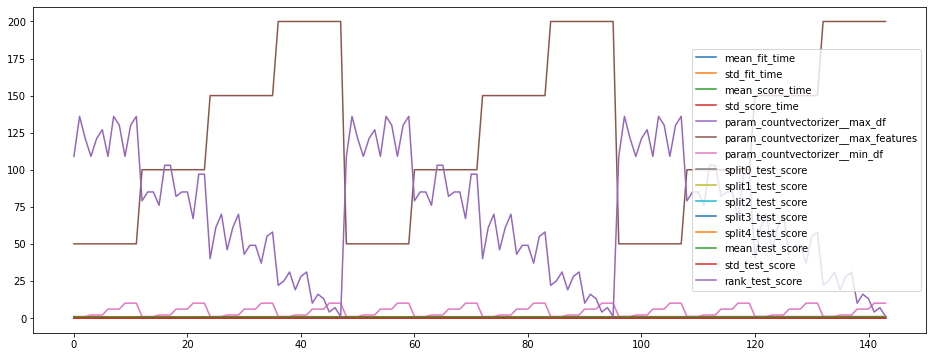

In [67]:
#what's going on here?  what should we do?
pd.DataFrame(grid.cv_results_).plot(figsize = (16,6))

# Requirements left:
- text data successfully converted to a numeric representation
- methods such as stop words, stemming, and lemmatization are explored
